In [7]:
import numpy as np, pandas as pd
from scipy import stats
from scipy import special
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Maximum Likelihood Estimators (MLE)

In [3]:
# https://towardsdatascience.com/a-gentle-introduction-to-maximum-likelihood-estimation-9fbff27ea12f

def mle_fit(samples):
    def cost(params):
        shape, loc, scale = params[0], params[1], params[2]

        negLL = -np.sum(stats.genextreme.logpdf(samples,shape,loc,scale))

        return(negLL)

    guess = np.array([0,np.mean(samples),np.std(samples)])
    results = minimize(cost, guess, method='Nelder-Mead',
                      options={'disp': False})
    return(results['x'])

# Probability Weighted Moments (PWM)

In [4]:
'''
    Gives the nth moment of the given samples
    xs : the samples
    moment: the moment wanted
'''
def moment(xs, moment):
    samples = np.sort(xs)
    n = samples.size
    res = 0
    for j, sample in enumerate(samples):
        term = sample
        for i in range(1,moment + 1):
            term = term * (j + 1 - i) / (n - i)
        res = res + term
    return res / n

'''
    Uses Hosking, et. al's PWM method for estimating GEV parameters
'''
def pwm_fit(samples):
    # Generate moments from sample data
    samples = np.sort(samples)
    n = samples.size
    b0 = moment(samples,0)
    b1 = moment(samples,1)
    b2 = moment(samples,2)

    # Generate GEV parameters
    c = (2*b1-b0)/(3*b2-b0) - np.log(2)/np.log(3)
    est_shape = 7.8590*c+2.9554*np.power(c,2)
    gamma = special.gamma(1 + est_shape)
    est_scale = est_shape*(2*b1-b0)/(gamma*(1-np.power(2,-est_shape)))
    est_loc = b0 + est_scale*(gamma-1)/est_shape
    return est_shape,est_loc,est_scale

# Method of Moments (MOM)

In [5]:
def mom_fit(samples):
    mean = np.mean(samples)
    std = np.std(samples)
    skew = stats.skew(samples)
    
    def cost(shape):
        numerator = -special.gamma(1+3*shape)+ \
                    3*special.gamma(1+shape)*special.gamma(1+2*shape)- \
                    2*special.gamma(1+shape)**3
        denominator = (special.gamma(1+2*shape) - \
                       special.gamma(1+shape)**2)**1.5
        cost = (np.sign(shape)*numerator/denominator - skew)**2
        return(cost)
    guess = 0
    shape = minimize(cost, guess, method='Nelder-Mead',
                          options={'disp': False})['x'][0]
    scale = std*np.abs(shape)/ \
            (special.gamma(1+2*shape) - \
             special.gamma(1+shape)**2)**0.5
    loc = mean - scale*(1-special.gamma(1+shape))/shape
    return(shape,loc,scale)

# Putting it all Together

In [89]:
# # GEV data generation

# shapes =  [0] #[-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3]
# locs = [0] #[0, 10]
# scales = [1] #[1, 5]
# sample_sizes = [15, 25, 50, 75, 100]
# iterations = 200

# gev_columns = ['sample size','shape','loc','scale','iteration',
#                'pwm shape','pwm loc','pwm scale',
#                'mle shape','mle loc','mle scale',
#                'mom shape','mom loc','mom scale',
#                'scipy shape','scipy loc','scipy scale']
# gev_df = pd.DataFrame(columns=gev_columns)

# i = 0
# for shape in shapes:
#     for loc in locs:
#         for scale in scales:
#             for sample_size in sample_sizes:
#                 for it in range(iterations):

#                     data = stats.genextreme.rvs(shape,loc,scale,sample_size)

#                     pwm_shape, pwm_loc, pwm_scale = pwm_fit(data)
#                     mle_shape, mle_loc, mle_scale = mle_fit(data)
#                     mom_shape, mom_loc, mom_scale = mom_fit(data)
#                     scipy_shape, scipy_loc, scipy_scale = stats.genextreme.fit(data)

#                     gev_df.loc[gev_df.shape[0]] = [sample_size,shape,loc,scale,it,
#                                                    pwm_shape,pwm_loc,pwm_scale,
#                                                    mle_shape,mle_loc,mle_scale,
#                                                    mom_shape,mom_loc,mom_scale,
#                                                    scipy_shape,scipy_loc,scipy_scale]
#                     i += 1
#                     print(str(i),end=' ')
# print()
# print(str(i) + ' GEV Iterations completed')

# EMMA data generation

dists = ['norm', 'pareto', 'expon', 'rayleigh', 'weibull_max']
locs = [0] #[0, 10]
scales = [1] #[1, 5]
sample_sizes = [15, 25, 50, 75, 100]
nodes = [50]
iterations = 10

phi = 0.570376002
emma_columns = ['dist','param','loc','scale','sample size','nodes','iteration',
                'emma emv','pwm emv','mle emv','mom emv','scipy emv']
emma_df = pd.DataFrame(columns=emma_columns)

i = 0
for loc in locs:
    for scale in scales:
        for sample_size in sample_sizes:
            for node in nodes:
                for dist in dists:
                    for it in range(iterations):
                        emma = 0
                        data = []
                        param = None
                        if dist == 'norm':
                            emma = stats.norm.ppf(phi**(1/node),loc,scale)
                            for j in range(sample_size):
                                data.append(np.max(stats.norm.rvs(loc,scale,node)))
                        elif dist == 'pareto':
                            param = 2.62
                            emma = stats.pareto.ppf(phi**(1/node),param,loc,scale)
                            for j in range(sample_size):
                                data.append(np.max(stats.pareto.rvs(param,loc,scale,node)))
                        elif dist == 'expon':
                            emma = stats.expon.ppf(phi**(1/node),loc,scale)
                            for j in range(sample_size):
                                data.append(np.max(stats.expon.rvs(loc,scale,node)))
                        elif dist == 'rayleigh':
                            emma = stats.rayleigh.ppf(phi**(1/node),loc,scale)
                            for j in range(sample_size):
                                data.append(np.max(stats.rayleigh.rvs(loc,scale,node)))
                        elif dist == 'weibull_max':
                            param = 2.87
                            emma = stats.weibull_max.ppf(phi**(1/node),param,loc,scale)
                            for j in range(sample_size):
                                data.append(np.max(stats.weibull_max.rvs(param,loc,scale,node)))
                        else:
                            continue

                        pwm_shape, pwm_loc, pwm_scale = pwm_fit(data)
                        mle_shape, mle_loc, mle_scale = mle_fit(data)
                        mom_shape, mom_loc, mom_scale = mom_fit(data)
                        scipy_shape, scipy_loc, scipy_scale = stats.genextreme.fit(data)
                        
                        pwm_emma = stats.genextreme.ppf(phi,pwm_shape,pwm_loc,pwm_scale)
                        mle_emma = stats.genextreme.ppf(phi,mle_shape,mle_loc,mle_scale)
                        mom_emma = stats.genextreme.ppf(phi,mom_shape,mom_loc,mom_scale)
                        scipy_emma = stats.genextreme.ppf(phi,scipy_shape,scipy_loc,scipy_scale)
                        
                        emma_df.loc[emma_df.shape[0]] = [dist,param,loc,scale,sample_size,node,it,
                                                         emma,pwm_emma,mle_emma,mom_emma,scipy_emma]
                        i += 1
                        print(str(i),end=' ')
print()
print(str(i) + ' EMMA Iterations completed')

c:\users\leaper\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
c:\users\leaper\appdata\local\programs\python\python36\lib\site-packages\scipy\optimize\optimize.py:620: RuntimeWarning: invalid value encountered in less
  if fxr < fsim[-1]:
c:\users\leaper\appdata\local\programs\python\python36\lib\site-packages\scipy\optimize\optimize.py:634: RuntimeWarning: invalid value encountered in less
  if fxcc < fsim[-1]:
c:\users\leaper\appdata\local\programs\python\python36\lib\site-packages\scipy\optimize\optimize.py:604: RuntimeWarning: invalid value encountered in less
  if fxr < fsim[0]:
c:\users\leaper\appdata\local\programs\python\python36\lib\site-packages\scipy\optimize\optimize.py:615: RuntimeWarning: invalid value encountered in less
  if fxr < fsim[-2]:
c:\users\leaper\appdata\local\programs\python\python36\lib\site-packages\scipy\optimize\optimize.py:608: Runtime

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 

c:\users\leaper\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\_continuous_distns.py:2402: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)


95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 
250 EMMA Iterations completed


expon


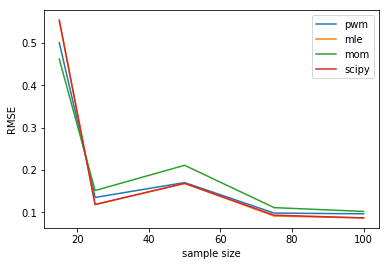

norm


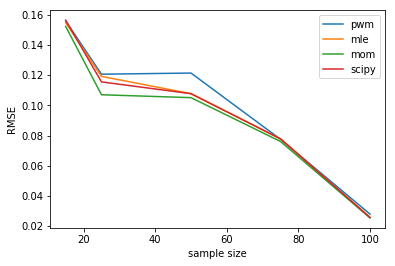

pareto


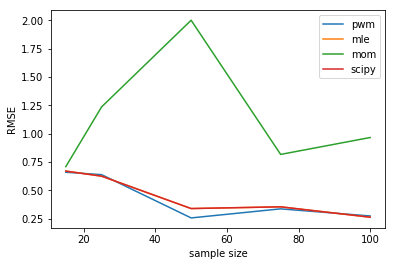

rayleigh


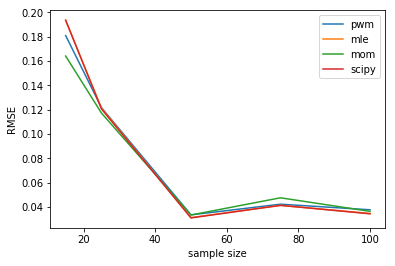

weibull_max


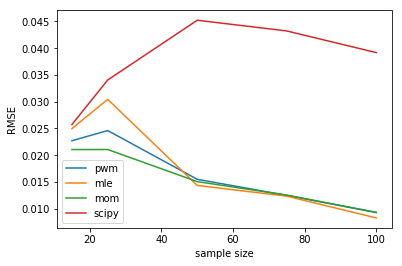

15


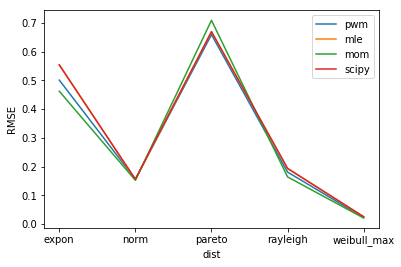

25


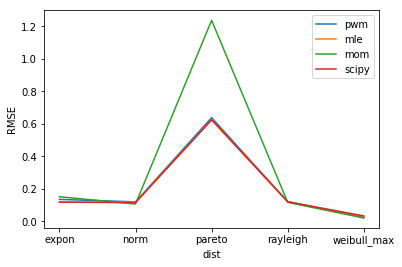

50


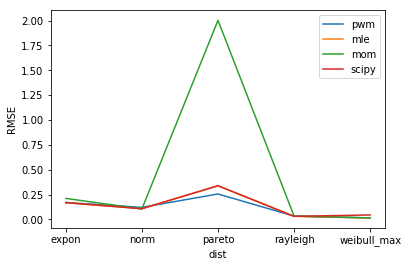

75


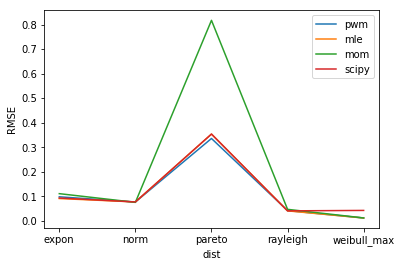

100


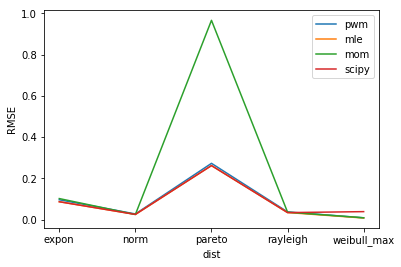

In [108]:
dfs = emma_df.groupby(['dist'])

for df in dfs:
    print(df[0])
    for method in ['pwm','mle','mom','scipy']:
        temp_df = pd.DataFrame({'size': df[1]['sample size'], method: df[1][method + ' emv'], 'emma': df[1]['emma emv']})
        temp_df['se'] = np.subtract(temp_df[method],temp_df['emma'])**2
        rmse = np.sqrt(temp_df.groupby(['size']).mean()['se'])
        plt.plot(rmse,label=method)
    plt.legend()
    plt.xlabel('sample size')
    plt.ylabel('RMSE')
    plt.show()
    
dfs = emma_df.groupby(['sample size'])
for df in dfs:
    print(df[0])
    for method in ['pwm','mle','mom','scipy']:
        temp_df = pd.DataFrame({'dist': df[1]['dist'], method: df[1][method + ' emv'], 'emma': df[1]['emma emv']})
        temp_df['se'] = np.subtract(temp_df[method],temp_df['emma'])**2
        rmse = np.sqrt(temp_df.groupby(['dist']).mean()['se'])
        plt.plot(rmse,label=method)
    plt.legend()
    plt.xlabel('dist')
    plt.ylabel('RMSE')
    plt.show()